### Modelo de recomendación de locales gastronómicos basado en K-Near Neighbors (KNN)

Los resultados obtenidos muestran que el valor de N=5 ofrece un equilibrio óptimo entre precisión y recall. Si bien N=2 logra una precisión ligeramente mayor, existe el riesgo de sobreajuste. Por otro lado, N=9, aunque ofrece un alto recall, presenta una ligera disminución en la precisión y el F1-score. Por lo tanto, se seleccionó N=5 como el valor óptimo para el modelo KNN, ya que permite obtener recomendaciones precisas y relevantes sin comprometer la capacidad de generalización.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


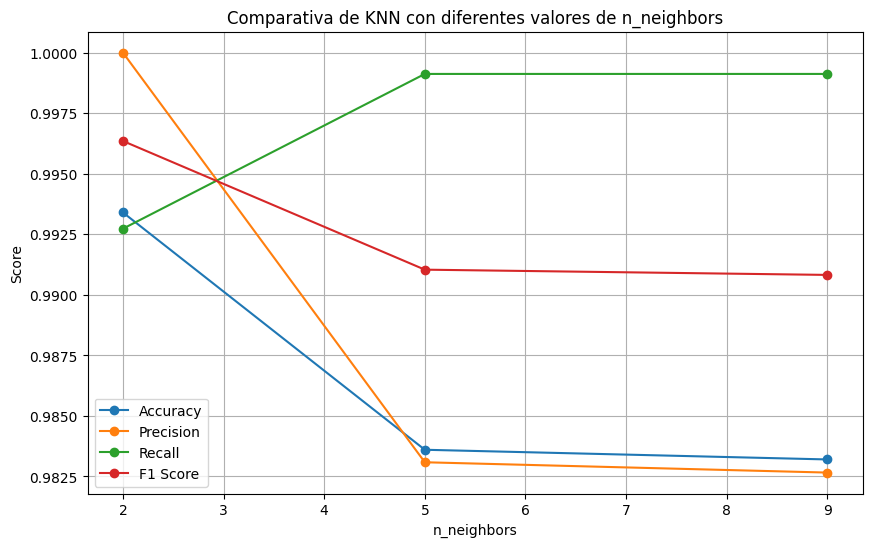

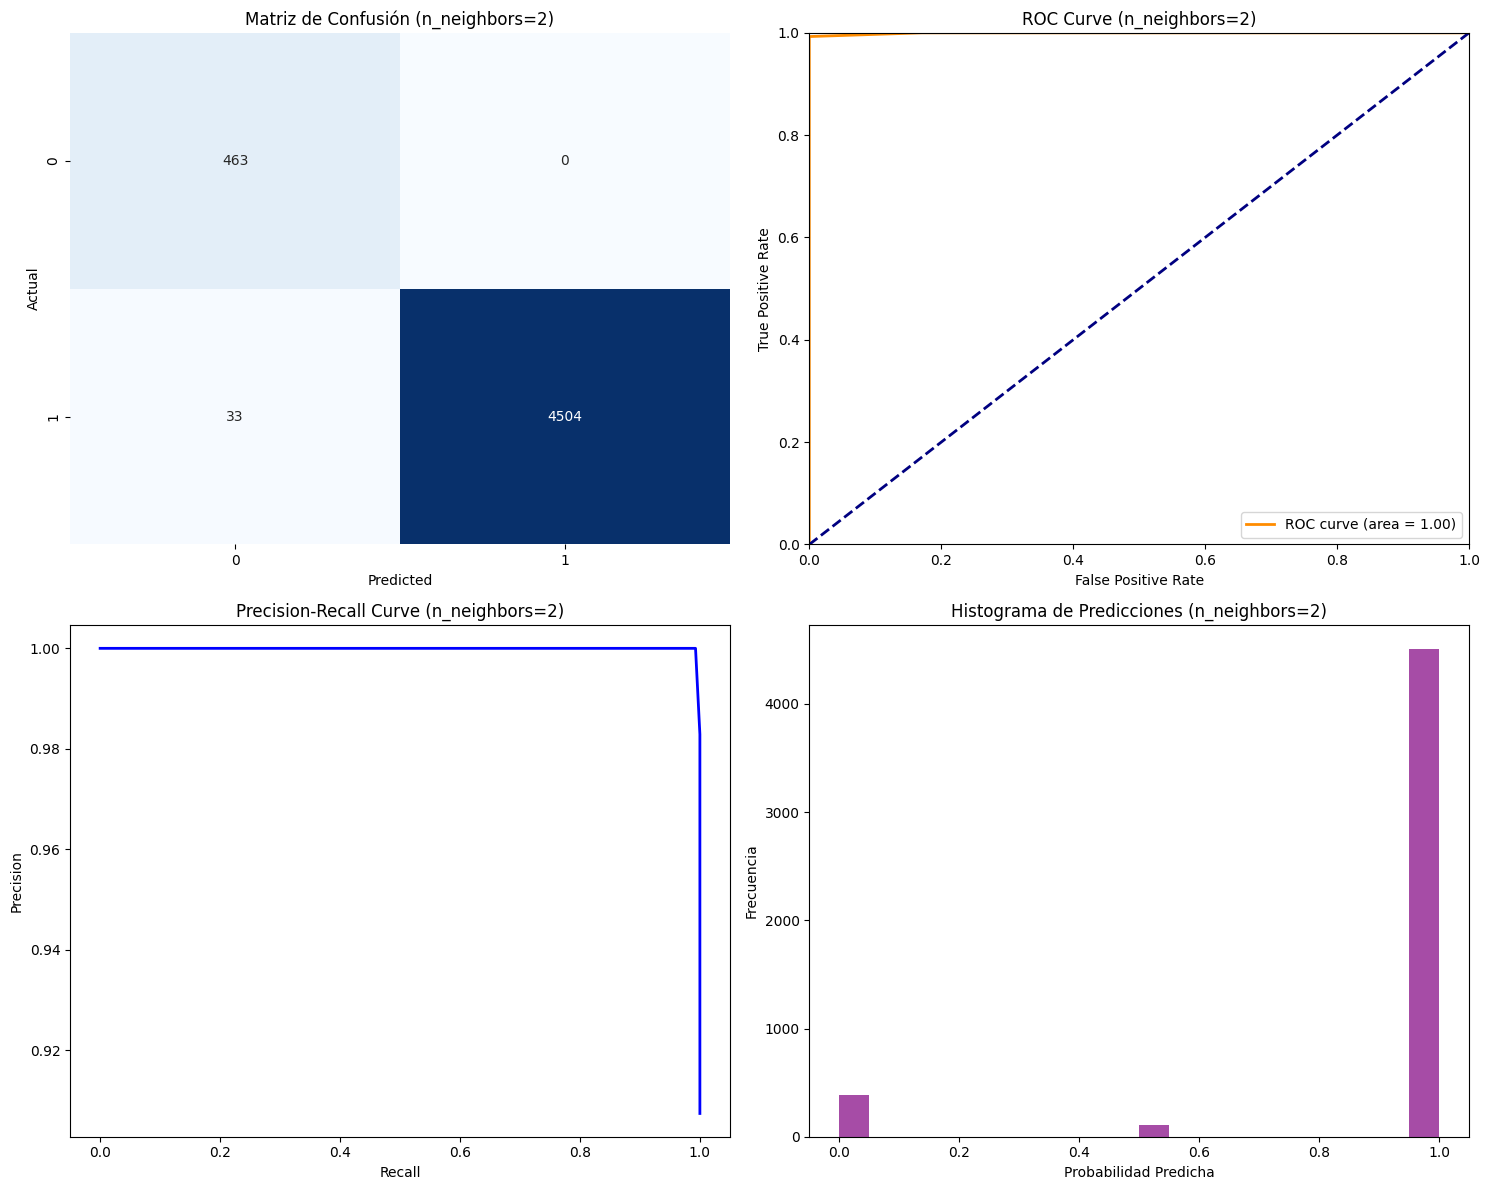

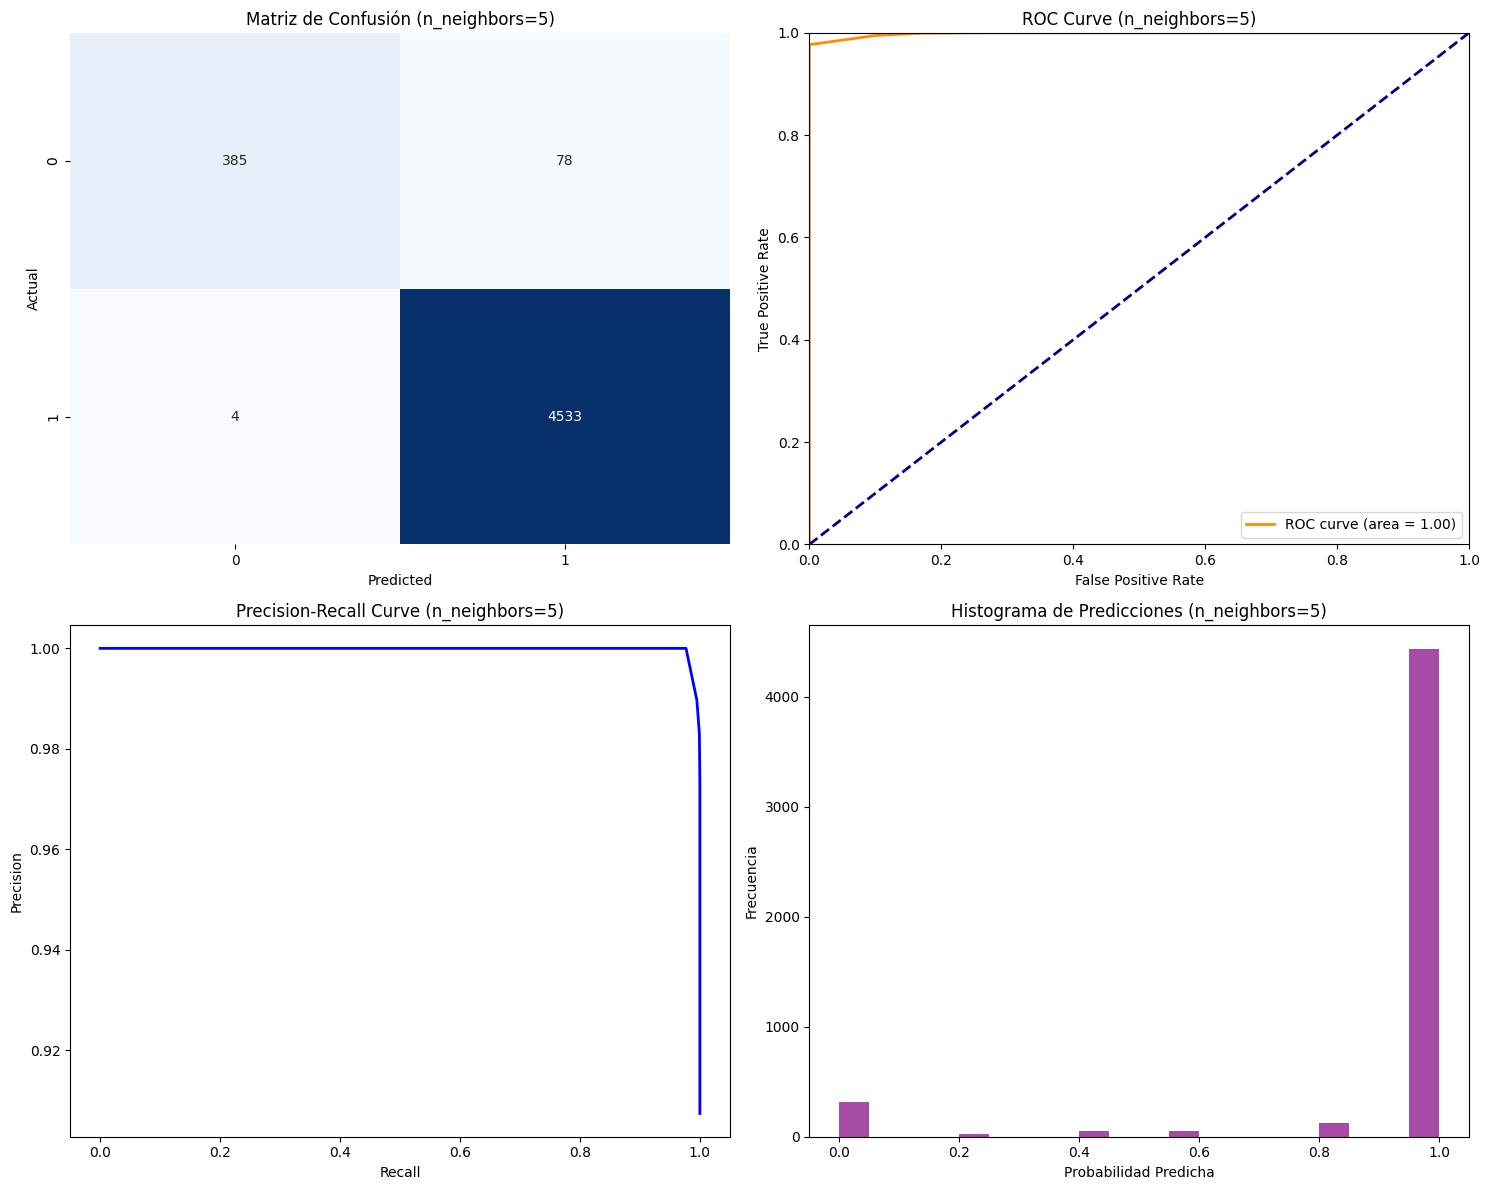

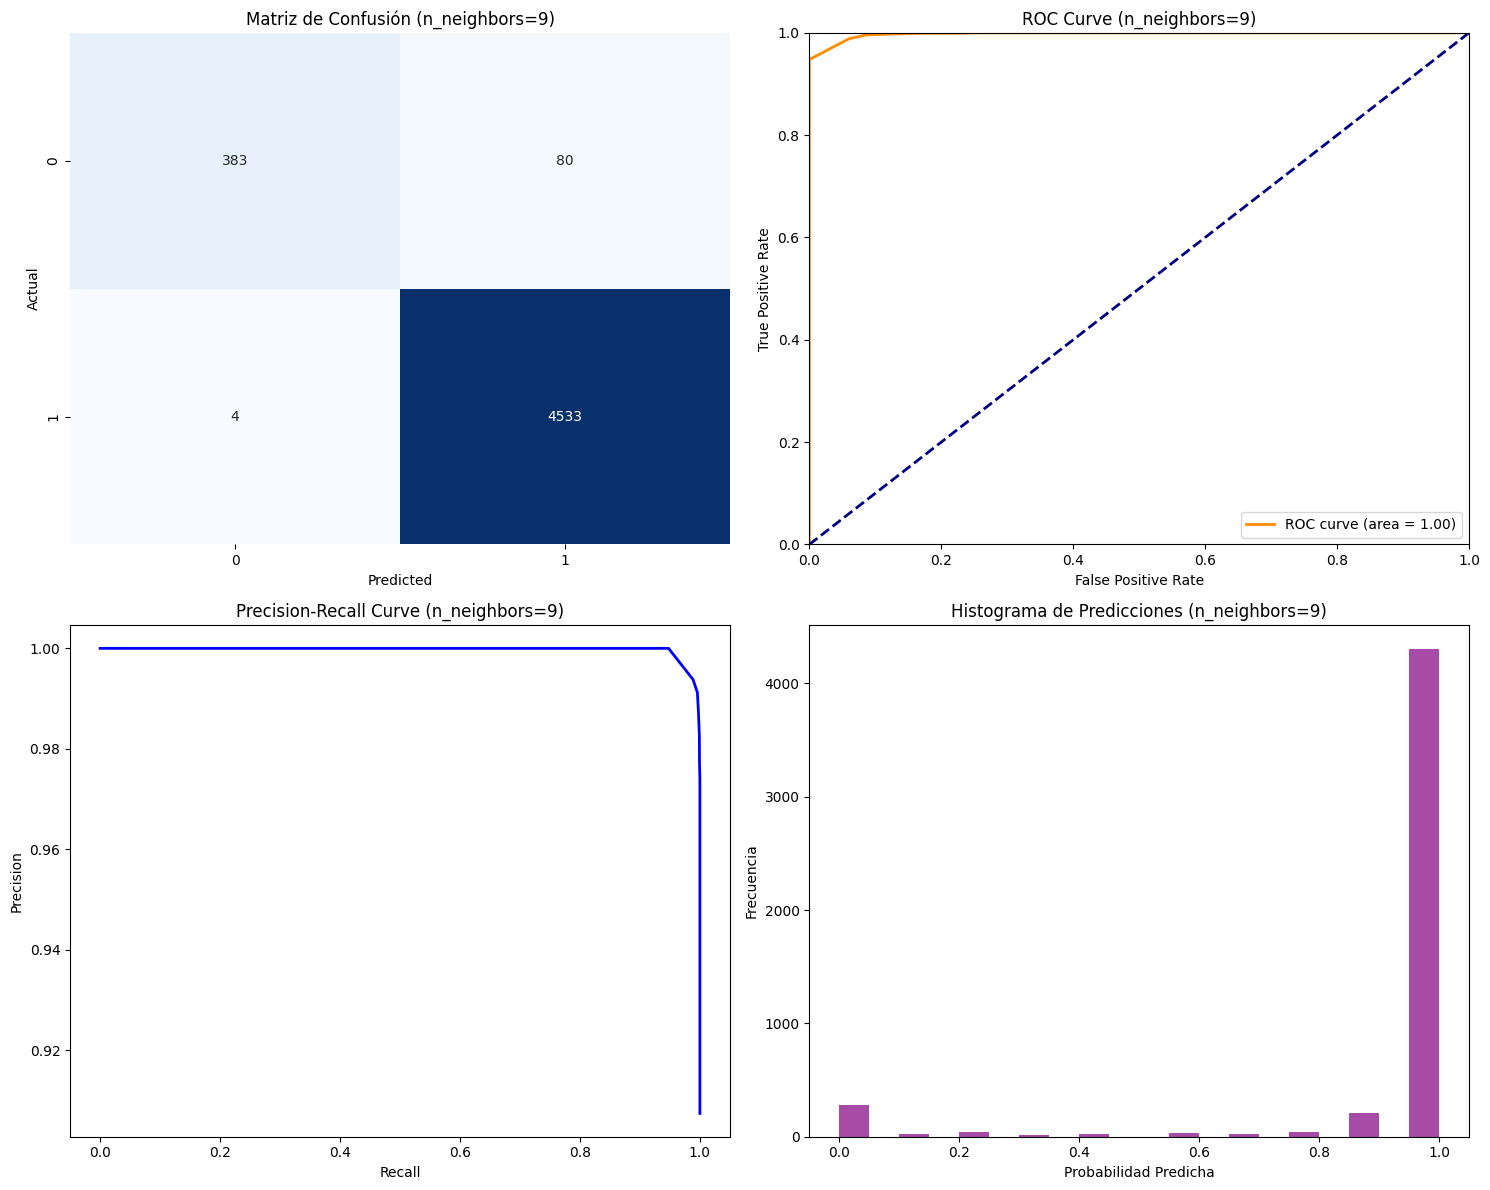

   n_neighbors  Accuracy  Precision    Recall  F1 Score
0            2    0.9934   1.000000  0.992726  0.996350
1            5    0.9836   0.983084  0.999118  0.991036
2            9    0.9832   0.982658  0.999118  0.990820


In [20]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Descarga de recursos necesarios
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

test = pd.read_csv('C:\\Users\\felip\\Desktop\\Horizon\\Data\\semilla2.csv')

# Función para preprocesar el texto
def preprocess_text(text):
    if pd.isna(text):
        return ""
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]
    return ' '.join(words)

# Entrenar y evaluar el modelo KNN
def train_and_evaluate_knn(n_neighbors):
    test['review_text'] = test['review_text'].fillna("")
    test['category'] = test['category'].fillna("")
    
    # Crear la columna objetivo
    test['target'] = np.where((test['avg_rating'] > 3.5) & (test['num_of_reviews'] > 20), 1, 0)
    
    # Preprocesamiento de texto
    test['comentario_preprocesado'] = test['review_text'].apply(preprocess_text)

    # Vectorización
    vectorizer = TfidfVectorizer(max_features=1000)
    X_text = vectorizer.fit_transform(test['comentario_preprocesado'])

    # Normalización de características numéricas
    scaler = StandardScaler()
    X_num = scaler.fit_transform(test[['num_of_reviews', 'avg_rating']])

    # Combinar características textuales y numéricas
    X = hstack([X_text, X_num])
    y = test['target']

    # Entrenar el modelo KNN
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X, y)
    
    # Obtener predicciones y probabilidades
    y_pred = knn_model.predict(X)
    y_pred_proba = knn_model.predict_proba(X)[:, 1]  # Probabilidad de la clase positiva
    
    return y_pred, y_pred_proba, knn_model

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_neighbors'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['n_neighbors'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['n_neighbors'], results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df['n_neighbors'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.title('Comparativa de KNN con diferentes valores de n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Graficar Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, ax, n_neighbors):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Matriz de Confusión (n_neighbors={n_neighbors})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Graficar Curva ROC
def plot_roc_curve(y_true, y_pred_proba, ax, n_neighbors):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve (n_neighbors={n_neighbors})')
    ax.legend(loc="lower right")

# Graficar Curva de Precisión-Recuperación
def plot_precision_recall_curve(y_true, y_pred_proba, ax, n_neighbors):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    ax.plot(recall, precision, lw=2, color='blue')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve (n_neighbors={n_neighbors})')

# Graficar Histograma de Predicciones
def plot_prediction_histogram(y_pred_proba, ax, n_neighbors):
    ax.hist(y_pred_proba, bins=20, color='purple', alpha=0.7)
    ax.set_title(f'Histograma de Predicciones (n_neighbors={n_neighbors})')
    ax.set_xlabel('Probabilidad Predicha')
    ax.set_ylabel('Frecuencia')

# Crear tabla de métricas
def create_metrics_table(y_true, y_pred, n_neighbors):
    metrics = {
        'n_neighbors': n_neighbors,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }
    return pd.DataFrame([metrics])

# Lista de vecinos a evaluar
n_neighbors_list = [2, 5, 9]
metrics_df = pd.DataFrame()

# Iterar sobre los valores de n_neighbors y generar gráficos
for n in n_neighbors_list:
    y_pred, y_pred_proba, knn_model = train_and_evaluate_knn(n)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Generar y mostrar los gráficos
    plot_confusion_matrix(test['target'], y_pred, axes[0, 0], n)
    plot_roc_curve(test['target'], y_pred_proba, axes[0, 1], n)
    plot_precision_recall_curve(test['target'], y_pred_proba, axes[1, 0], n)
    plot_prediction_histogram(y_pred_proba, axes[1, 1], n)
    
    plt.tight_layout()
    plt.show()
    
    # Actualizar la tabla de métricas
    metrics_df = pd.concat([metrics_df, create_metrics_table(test['target'], y_pred, n)], ignore_index=True)

# Mostrar la tabla de métricas
print(metrics_df)
